# Speech emotion recognition using MFCC features

In this notebook I practise and experiment with:
* Extracting MFCC features from audio signals using librosa.feature.mfcc
* Applying MFCC features to speech emotion recognition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from pydub import AudioSegment
from pydub.utils import mediainfo
import os

## 1. MFCC

Suppose that we want to extract 12 MFCC features from the cepstrum of the signal in arctic_a0005.wav. The code below shows how to extract MFCC features.

In [ ]:
speech = AudioSegment.from_wav('../resources/arctic_a0005.wav')
x = speech.get_array_of_samples()
x_sr = speech.frame_rate
mfcc = librosa.feature.mfcc(np.float32(x),
                            sr = x_sr,
                            hop_length = int(x_sr * 0.015),
                            n_mfcc = 12)

The MFCC features are the cepstral features extracted on the cepstrum (i.e., the inverse Fourier
transform of the log magnitude spectrum). The following code visualises the MFCC features. In this code, I
first get the transpose of mfcc, and then flatten it. 

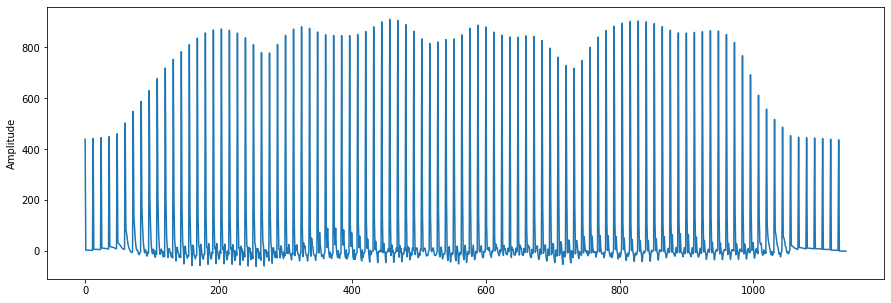

In [33]:
mfcc_flattened = np.reshape(mfcc.T, (mfcc.shape[0] * mfcc.shape[1]))
plt.figure(figsize = (15, 5))
plt.plot(mfcc_flattened)
plt.ylabel('Amplitude')
plt.savefig('Amplitude.png')

## 2. Speech emotion recognition
In this section, I will apply the MFCC features to describe speech signals for speech emotion recognition. I
will use a small dataset called EmotionSpeech. This dataset is a part of the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS).

The folder EmotionSpeech includes two sub-folders: Train and Test. Each Train/Test contains 128 clips (of about 4s) used for training and testing speech emotion recognition models respectively. In each Train/Test folder, there are 4 sub-folders containing audio data for 4 different emotions: calm, happy, sad, and angry. The audio clips for each emotion type are captured by 8 different actors (4 males and 4 females). However, audio clips from the same actor are used for either training or testing (but not both), e.g., clips from the first 4 actors are used for training and clips from the other 4 actors are used for testing. Each actor speaks two statements including "Kids are talking by the door" and "Dogs are sitting by the door". Each statement is spoken two times.

The below code iterates through all the folders and created a list of labels and filenames for processing.

In [51]:
emotions = ['Calm', 'Happy', 'Sad', 'Angry']
path = './Resources_8.1/EmotionSpeech/'

training_file_names = []
training_emotion_labels = []

test_file_names = []
test_emotion_labels = []

for i in range(0, len(emotions)):
    sub_path = path + 'Train/' + emotions[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_emotion_labels += sub_emotion_labels
    
for i in range(0, len(emotions)):
    sub_path = path + 'Test/' + emotions[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names)
    test_file_names += sub_file_names
    test_emotion_labels += sub_emotion_labels

I implement a method, named mfcc_extraction to extract mfcc features from an input audio file

In [52]:
def mfcc_extraction(audio_filename,
                    hop_duration,
                    num_mfcc,
                    num_frames
                   ):
    """ Uses librosa.feature.mfcc to extract MFCC features."""                
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate

    mfcc = librosa.feature.mfcc(
        np.float32(samples),
        sr = sampling_rate,
        hop_length = int(sampling_rate * hop_duration),
        n_mfcc = num_mfcc)

    mfcc_truncated = np.zeros((num_mfcc, num_frames), np.float32)
    for i in range(min(num_frames, mfcc.shape[1])):
        mfcc_truncated[:, i] = mfcc[:, i]

    return np.reshape(mfcc_truncated.T, mfcc_truncated.shape[0] * mfcc_truncated.shape[1])

In [1]:
def get_mfcc(file_names, n_features):
    """ Gets n MFCC features from a given file and returns a list."""
    mfcc_list = []
    for file in file_names:
        mfcc_list.append(mfcc_extraction(audio_filename=file, hop_duration=0.015, num_mfcc=n_features, num_frames=200))
        mfcc = np.array(mfcc_list)
    return mfcc

Get the train and set set MFCC features

In [109]:
train_mfcc = get_mfcc(training_file_names, 12)
test_mfcc = get_mfcc(test_file_names, 12)

In [55]:
train_mfcc.shape

(128, 2400)

## Build and train a SVM model

In [61]:
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

from pycm import *
import seaborn as sns

In [57]:
def plot_conf_matrix(data, labels, Title=None):
    plt.figure(figsize=(10,9))
    plt.title(Title)
    chart = sns.heatmap(data, cmap='OrRd', square=True,
                        annot=True, linewidths=1, linecolor='white',
                        yticklabels=labels, xticklabels=labels, fmt='.3f',
                        cbar_kws={'fraction' : 0.1})
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    chart.set_yticklabels(chart.get_yticklabels(), rotation=45, horizontalalignment='right')
    plt.show

Build the SVM model

              precision    recall  f1-score   support

        Calm     0.6444    0.9062    0.7532        32
       Happy     0.6316    0.3750    0.4706        32
         Sad     0.5238    0.6875    0.5946        32
       Angry     0.8182    0.5625    0.6667        32

    accuracy                         0.6328       128
   macro avg     0.6545    0.6328    0.6213       128
weighted avg     0.6545    0.6328    0.6213       128



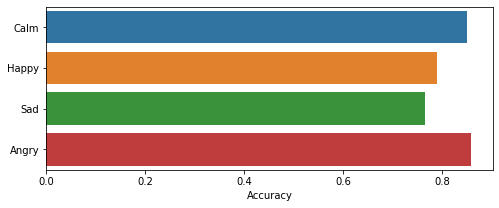

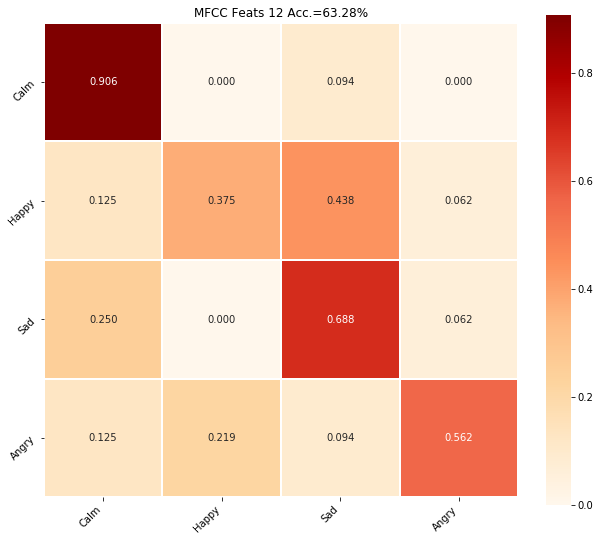

In [110]:
svm_classifier = svm.SVC(C = 1.0,
                     kernel = 'linear', random_state=42)
svm_classifier.fit(train_mfcc, training_emotion_labels)

predicted_labels = svm_classifier.predict(test_mfcc)

cm = confusion_matrix(test_emotion_labels, predicted_labels, normalize='true')

accs = dict(zip(emotions, list(ConfusionMatrix(test_emotion_labels, predicted_labels).class_stat['ACC'].values())))

plt.figure(figsize=(8,3))
sns.barplot(x=list(accs.values()), y=list(accs.keys()))
plt.xlabel('Accuracy')

plot_conf_matrix(cm, emotions, f'MFCC Feats {12} Acc.={accuracy_score(test_emotion_labels, predicted_labels)*100:.2f}%')

print(classification_report(test_emotion_labels, predicted_labels, target_names=emotions, digits=4))

I evaluated a linear SVM model several times using different `C` values and determined that `c=1.0` was achieving the best overall accuracy score (63.28%). The SVM model achieved high recall score for the `Calm` class (0.91) however the precision was a fair amount lower (0.64). The model does struggle to differentiate `happy` and `sad` emotions with 43.8% of `Sad` clips being classified as `Happy` which is slightly concerning. It also struggled with classification of the `Sad` class, incorrectly classifying 25% as `Calm`.

After determining the best C value, I experimented with the number of mfcc features used. A SVM was trained for each feature setting [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]. The best accuracy was achieved with num_mfcc=20 scoring an overall accuracy of 64.84%

In [107]:
feature_sizes = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30] 

for feat in feature_sizes:
    train_mfcc = get_mfcc(training_file_names, feat)
    test_mfcc = get_mfcc(test_file_names, feat)
    
    svm_classifier = svm.SVC(C = 1.0,
                     kernel = 'linear', random_state=42, )
    svm_classifier.fit(train_mfcc, training_emotion_labels)
    predicted_labels = svm_classifier.predict(test_mfcc)
    
    class_accs = list(ConfusionMatrix(test_emotion_labels, predicted_labels).class_stat['ACC'].values()) 
    class_accs = [ '%.3f' % elem for elem in class_accs]
    
    accs = dict(zip(emotions, class_accs))
    overall_acc = f'{accuracy_score(test_emotion_labels, predicted_labels)*100:.2f}'
    
    print(f"""Acc. for num_mfcc={feat}: {overall_acc}% - Class accuracies: {accs}""")    

Acc. for num_mfcc=12: 63.28% - Class accuracies: {'Calm': '0.852', 'Happy': '0.789', 'Sad': '0.766', 'Angry': '0.859'}
Acc. for num_mfcc=14: 63.28% - Class accuracies: {'Calm': '0.852', 'Happy': '0.789', 'Sad': '0.766', 'Angry': '0.859'}
Acc. for num_mfcc=16: 63.28% - Class accuracies: {'Calm': '0.844', 'Happy': '0.789', 'Sad': '0.773', 'Angry': '0.859'}
Acc. for num_mfcc=18: 63.28% - Class accuracies: {'Calm': '0.844', 'Happy': '0.789', 'Sad': '0.773', 'Angry': '0.859'}
Acc. for num_mfcc=20: 64.84% - Class accuracies: {'Calm': '0.844', 'Happy': '0.805', 'Sad': '0.789', 'Angry': '0.859'}
Acc. for num_mfcc=22: 64.06% - Class accuracies: {'Calm': '0.844', 'Happy': '0.797', 'Sad': '0.781', 'Angry': '0.859'}
Acc. for num_mfcc=24: 64.06% - Class accuracies: {'Calm': '0.844', 'Happy': '0.797', 'Sad': '0.781', 'Angry': '0.859'}
Acc. for num_mfcc=26: 62.50% - Class accuracies: {'Calm': '0.828', 'Happy': '0.797', 'Sad': '0.766', 'Angry': '0.859'}
Acc. for num_mfcc=28: 62.50% - Class accuracies:

## Build and train a AdaBoost model

In [59]:
from sklearn.ensemble import AdaBoostClassifier

              precision    recall  f1-score   support

        Calm     0.5400    0.8438    0.6585        32
       Happy     0.4000    0.1875    0.2553        32
         Sad     0.2188    0.2188    0.2188        32
       Angry     0.6452    0.6250    0.6349        32

    accuracy                         0.4688       128
   macro avg     0.4510    0.4688    0.4419       128
weighted avg     0.4510    0.4688    0.4419       128



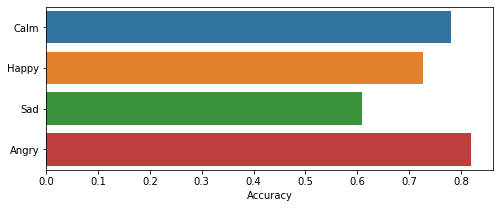

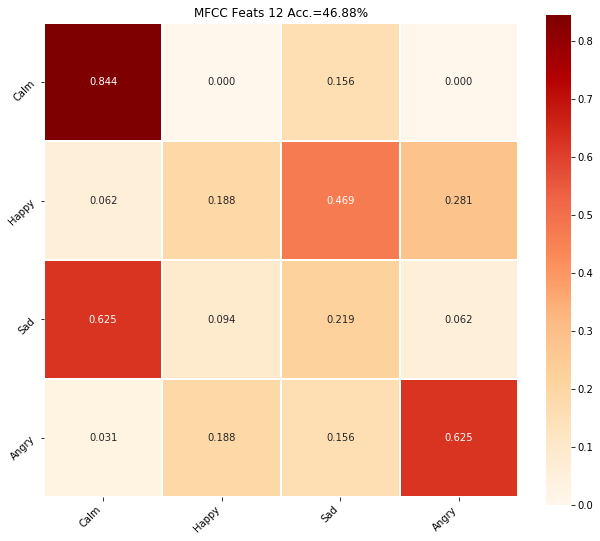

In [86]:
adb_classifier = AdaBoostClassifier(n_estimators=150, random_state=42)
adb_classifier.fit(train_mfcc, training_emotion_labels)

predicted_labels = adb_classifier.predict(test_mfcc)

cm = confusion_matrix(test_emotion_labels, predicted_labels, normalize='true')

accs = dict(zip(emotions, list(ConfusionMatrix(test_emotion_labels, predicted_labels).class_stat['ACC'].values())))

plt.figure(figsize=(8,3))
sns.barplot(x=list(accs.values()), y=list(accs.keys()))
plt.xlabel('Accuracy')

cm = confusion_matrix(test_emotion_labels, predicted_labels, normalize='true')
plot_conf_matrix(cm, emotions, f'MFCC Feats {12} Acc.={accuracy_score(test_emotion_labels, predicted_labels)*100:.2f}%')

print(classification_report(test_emotion_labels, predicted_labels, target_names=emotions, digits=4))

I evaluated a AdaBoost model several times using different n_estimators values and determined that n_estimators=150 was achieving the best overall accuracy score (46.88%). The AdaBoost model achieved reasonable recall score for the `Calm` class (0.84) the precision was, again, a fair amount lower (0.54).Like the SVM, The AdaBoost model struggled with classification of the `Calm` class, incorrectly classifying 62.5% as `Sad`.

After determining the best n_estimators value, I experimented with the number of mfcc features used. A AdaBoost model was trained for each feature setting [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]. The best accuracy was again achieved with num_mfcc=20 scoring an overall accuracy of 47.66%. 

In [108]:
feature_sizes = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30] 

for feat in feature_sizes:
    train_mfcc = get_mfcc(training_file_names, feat)
    test_mfcc = get_mfcc(test_file_names, feat)
    
    adb_classifier = AdaBoostClassifier(n_estimators=150, random_state=42)
    
    adb_classifier.fit(train_mfcc, training_emotion_labels)
    predicted_labels = adb_classifier.predict(test_mfcc)
    
    class_accs = list(ConfusionMatrix(test_emotion_labels, predicted_labels).class_stat['ACC'].values()) 
    class_accs = [ '%.3f' % elem for elem in class_accs]
    
    accs = dict(zip(emotions, class_accs))
    overall_acc = f'{accuracy_score(test_emotion_labels, predicted_labels)*100:.2f}'
    
    print(f"""Acc. for num_mfcc={feat}: {overall_acc}% - Class accuracies: {accs}""")

Acc. for num_mfcc=12: 46.88% - Class accuracies: {'Calm': '0.781', 'Happy': '0.727', 'Sad': '0.609', 'Angry': '0.820'}
Acc. for num_mfcc=14: 40.62% - Class accuracies: {'Calm': '0.672', 'Happy': '0.719', 'Sad': '0.625', 'Angry': '0.797'}
Acc. for num_mfcc=16: 42.19% - Class accuracies: {'Calm': '0.797', 'Happy': '0.664', 'Sad': '0.570', 'Angry': '0.812'}
Acc. for num_mfcc=18: 40.62% - Class accuracies: {'Calm': '0.773', 'Happy': '0.742', 'Sad': '0.461', 'Angry': '0.836'}
Acc. for num_mfcc=20: 47.66% - Class accuracies: {'Calm': '0.820', 'Happy': '0.750', 'Sad': '0.578', 'Angry': '0.805'}
Acc. for num_mfcc=22: 46.88% - Class accuracies: {'Calm': '0.805', 'Happy': '0.734', 'Sad': '0.586', 'Angry': '0.812'}
Acc. for num_mfcc=24: 40.62% - Class accuracies: {'Calm': '0.789', 'Happy': '0.711', 'Sad': '0.508', 'Angry': '0.805'}
Acc. for num_mfcc=26: 36.72% - Class accuracies: {'Calm': '0.758', 'Happy': '0.727', 'Sad': '0.500', 'Angry': '0.750'}
Acc. for num_mfcc=28: 37.50% - Class accuracies:

## Summary
Overall the Linear SVM model performed better than the Adaboost counterparts. The SVM achieved higher accuracy scores overall as well as across all classes, irrespective of the number of MFCC features used.

Interestingly both algorithms performed best when using 20 MFCC features per frame. The AdaBoost algorithm was more sensative to the number of MFCC features used resulting in accuracy scores ranging from 35.16%  to 47.66% (12.5 percentage points) while the SVM’s range was only 62.5% to 64.84 (2.34 percentage points).